In [1]:
#|default_exp training

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F

In [3]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'

In [4]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('../data')
path_data.mkdir(exist_ok=True)
path_gz = path_data / 'mnist.pkl.gz'

from urllib.request import urlretrieve
if not path_gz.exists():
    urlretrieve(MNIST_URL, path_gz)

with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In [5]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

# Setup

## Data

In [6]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [7]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [
            nn.Linear(n_in, nh),
            nn.ReLU(),
            nn.Linear(nh, n_out)
        ]
    
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [8]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

## Cross Entropy Loss

$$ softmax(x)_i = \frac{e^{x_i}}{\sum_{0<=j<n}{x^x_j}} $$

In [9]:
def log_softmax(x):
    return (x.exp() / (x.exp().sum(-1, keepdim=True))).log()

In [10]:
log_softmax(pred)

tensor([[-2.49, -2.30, -2.43,  ..., -2.17, -2.36, -2.09],
        [-2.48, -2.30, -2.35,  ..., -2.25, -2.34, -2.14],
        [-2.51, -2.37, -2.39,  ..., -2.30, -2.35, -2.19],
        ...,
        [-2.47, -2.34, -2.41,  ..., -2.27, -2.32, -2.10],
        [-2.44, -2.34, -2.32,  ..., -2.18, -2.36, -2.14],
        [-2.49, -2.28, -2.40,  ..., -2.23, -2.38, -2.07]], grad_fn=<LogBackward0>)

In [11]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()

In [12]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x - m[:, None]).exp().sum(-1).log()

In [13]:
def log_softmax(x):
    return x - x.logsumexp(-1, keepdim=True)

In [14]:
test_close(logsumexp(pred), pred.logsumexp(-1))
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.49, -2.30, -2.43,  ..., -2.17, -2.36, -2.09],
        [-2.48, -2.30, -2.35,  ..., -2.25, -2.34, -2.14],
        [-2.51, -2.37, -2.39,  ..., -2.30, -2.35, -2.19],
        ...,
        [-2.47, -2.34, -2.41,  ..., -2.27, -2.32, -2.10],
        [-2.44, -2.34, -2.32,  ..., -2.18, -2.36, -2.14],
        [-2.49, -2.28, -2.40,  ..., -2.23, -2.38, -2.07]], grad_fn=<SubBackward0>)

In [15]:
y_train[:3]

tensor([5, 0, 4])

In [16]:
sm_pred[0, 5], sm_pred[1, 0], sm_pred[2, 4]

(tensor(-2.06, grad_fn=<SelectBackward0>),
 tensor(-2.48, grad_fn=<SelectBackward0>),
 tensor(-2.43, grad_fn=<SelectBackward0>))

In [17]:
sm_pred[[0, 1, 2], y_train[:3]]

tensor([-2.06, -2.48, -2.43], grad_fn=<IndexBackward0>)

In [18]:
def nll(input, targ):
    return -input[range(targ.shape[0]), targ].mean()

In [19]:
loss = nll(sm_pred, y_train)
loss

tensor(2.32, grad_fn=<NegBackward0>)

In [20]:
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)

In [21]:
test_close(F.cross_entropy(pred, y_train), loss, 1e-3)

## Basic Training Loop

In [22]:
loss_func = F.cross_entropy

In [23]:
bs = 50 # batch size

xb = x_train[0:bs] # a mini-batch from x
preds = model(xb)  # preds
preds[0], preds.shape

(tensor([-0.14,  0.04, -0.08, -0.08, -0.13,  0.28, -0.01,  0.17, -0.01,  0.26], grad_fn=<SelectBackward0>),
 torch.Size([50, 10]))

In [24]:
yb = y_train[:bs]; yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
        3, 9, 8, 5, 9, 3])

In [25]:
loss_func(preds, yb)

tensor(2.31, grad_fn=<NllLossBackward0>)

In [26]:
preds.argmax(dim=1)

tensor([5, 5, 5, 9, 9, 5, 9, 5, 9, 9, 9, 5, 5, 5, 9, 5, 5, 9, 5, 5, 5, 5, 9, 9, 9, 5, 9, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 9, 9, 5,
        5, 9, 9, 9, 9, 9])

In [27]:
#|export 
def accuracy(out, yb):
    return (out.argmax(dim=1)==yb).float().mean()

In [28]:
accuracy(preds, yb)

tensor(0.14)

In [29]:
lr = 0.5     # learning rate
epochs = 3   # epochs to train for

In [30]:
#|export
def report(loss, preds, yb):
    print(f"{loss:.2f}, {accuracy(preds, yb):.2f}")

In [31]:
xb, yb = x_train[:bs], y_train[:bs]
preds = model(xb)
report(loss_func(preds, yb), preds, yb)

2.31, 0.14


In [32]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        
        with torch.inference_mode():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()
        
    report(loss, preds, yb)

0.16, 0.96
0.11, 0.98
0.12, 0.98


## Using parameters and optim

In [33]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.l2(self.relu(self.l1(x)))

In [34]:
model = MLP(m, nh, 10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [35]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [36]:
for name, l in model.named_children():
    print(f"{name}:\t{l}")

l1:	Linear(in_features=784, out_features=50, bias=True)
l2:	Linear(in_features=50, out_features=10, bias=True)
relu:	ReLU()


In [37]:
for p in model.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [38]:
torch.tensor([p.numel() for p in model.parameters()]).sum()

tensor(39760)

In [39]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n, i+bs))
            xb, yb = x_train[s], y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            
            with torch.inference_mode():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()
        
        report(loss, preds, yb)

In [40]:
fit()

0.14, 0.94
0.12, 0.96
0.10, 0.98


In [41]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        
    def __setattr__(self, k, v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k, v)
        
    def __repr__(self): return f"{self._modules}"

    def parameters(self):
        for l in self._modules.values():
            yield from l.parameters()

In [42]:
mdl = MyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [43]:
for p in mdl.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


### Registering Modules

In [45]:
from functools import reduce

In [46]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [47]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers):
            self.add_module(f"layer_{i}", l)
            
    def forward(self, x):
        return reduce(lambda val, layer: layer(val), self.layers, x)

In [48]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [49]:
model(xb).shape

torch.Size([50, 10])

### nn.ModuleList

In [50]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [51]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [52]:
fit()

0.11, 0.98
0.08, 0.98
0.10, 0.94


### nn.Sequential

In [53]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [54]:
fit()

0.24, 0.90
0.20, 0.94
0.13, 0.98


In [55]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.04, grad_fn=<NllLossBackward0>), tensor(1.))

In [56]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### optim

In [57]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params, self.lr = list(params), lr
        
    def step(self):
        with torch.inference_mode():
            for p in self.params:
                p -= p.grad * self.lr
                
    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

In [58]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [59]:
opt = Optimizer(model.parameters())

In [60]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.12, 0.98
0.09, 0.96
0.09, 0.96


In [61]:
from torch import optim

In [62]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [63]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [64]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.16, 0.96
0.10, 0.98
0.04, 1.00


## Dataset and DataLoader

### Dataset

In [66]:
#|export
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [67]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [68]:
xb, yb = train_ds[:5]
assert xb.shape == (5, 28*28)
assert yb.shape == (5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [69]:
model, opt = get_model()

In [70]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb, yb = train_ds[i:min(n, i+bs)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.13, 0.98
0.11, 0.96
0.12, 0.94


### DataLoader

In [71]:
class DataLoader():
    def __init__(self, ds, bs):
        self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [72]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [73]:
xb, yb = next(iter(valid_dl))
xb.shape

torch.Size([50, 784])

In [74]:
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3,
        8, 3, 7, 7, 8, 4])

tensor(3)

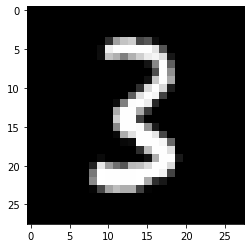

In [75]:
plt.imshow(xb[0].view(28, 28))
yb[0]

In [76]:
model, opt = get_model()

In [77]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        report(loss, preds, yb)

In [78]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.07, 0.98
0.03, 1.00
0.04, 1.00


(tensor(0.05, grad_fn=<NllLossBackward0>), tensor(1.))

### Random Sampling

In [79]:
import random

In [80]:
class Sampler():
    def __init__(self, ds, shuffle=False):
        self.n, self.shuffle = len(ds), shuffle
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)

In [81]:
from itertools import islice

In [82]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[4318, 40552, 10267, 21084, 12132]

In [83]:
import fastcore.all as fc

In [84]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
    def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [85]:
batchs = BatchSampler(ss, 4)
list(islice(batchs, 5))

[[23507, 1161, 15066, 1269],
 [39242, 7070, 604, 26228],
 [15648, 8437, 25182, 9371],
 [45034, 7860, 16641, 3390],
 [35671, 12701, 37612, 28180]]

In [86]:
batchs = BatchSampler(ss, 4)
list(islice(batchs, 5))

[[4160, 43402, 35975, 25193],
 [23160, 29973, 7861, 3820],
 [9538, 28604, 297, 12391],
 [33966, 27451, 18315, 17519],
 [39186, 41577, 46186, 2321]]

In [88]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [89]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [90]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [91]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

tensor(3)

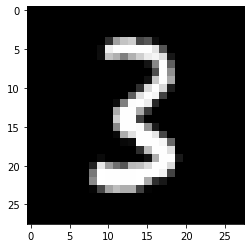

In [92]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28, 28))
yb[0]

In [93]:
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [94]:
model, opt = get_model()

In [95]:
fit()

0.29, 0.92
0.29, 0.92
0.01, 1.00


### Multiprocessing DataLoader

In [96]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [97]:
train_ds[[3, 6, 8, 1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [98]:
train_ds.__getitem__([3, 6, 8, 1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [99]:
for o in map(train_ds.__getitem__, ([3, 6], [8, 1])): print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


In [100]:
class DataLoader():
    def __init__(self, ds, batchs, n_workers=2, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex:
            yield from ex.map(self.ds.__getitem__, iter(self.batchs))

In [101]:
train_dl = DataLoader(train_ds, batchs=train_samp, n_workers=1)
it = iter(train_dl)

In [102]:
xb, yb = next(it)
xb.shape, yb.shape

KeyboardInterrupt: 

## Pytorch DataLoader

In [103]:
#|export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [104]:
train_samp = BatchSampler(RandomSampler(train_ds), bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [105]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [106]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.35, 0.88
0.06, 0.98
0.23, 0.92


(tensor(0.02, grad_fn=<NllLossBackward0>), tensor(1.))

In [107]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [108]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=4)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=4)

In [109]:
model, opt = get_model()
fit()

0.20, 0.96
0.12, 0.94
0.21, 0.88


In [110]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.04, grad_fn=<NllLossBackward0>), tensor(1.))

In [111]:
train_ds[[4, 6, 7]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 1, 3]))

In [112]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [113]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([1, 50, 784]), torch.Size([1, 50]))

## Validation

In [114]:
#|export
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        with torch.inference_mode():
            tot_loss, tot_acc, count = 0., 0., 0
            for xb, yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred, yb).item() * n
                tot_acc += accuracy(pred, yb).item() * n
        
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [115]:
#|export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [116]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()

In [117]:
%time loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.14921452097594737 0.9547000020742417
1 0.13020161424297838 0.9611000061035156
2 0.10584670537151396 0.9684000068902969
3 0.11151350852567703 0.9669000071287155
4 0.09989078638609498 0.9708000063896179
CPU times: user 18.1 s, sys: 26.1 ms, total: 18.1 s
Wall time: 4.54 s


# Export -

In [1]:
import nbdev
nbdev.nbdev_export()